Once again using the Natural Earth country boundaries as a backdrop for the map data

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import pandas as pd
from shapely.geometry import Point

In [2]:
countries = gpd.read_file("../map2_lines/natural_earth/ne_10m_admin_0_countries.shp")

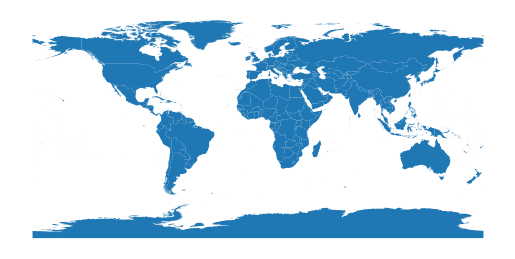

In [6]:
fig, ax = plt.subplots()
countries.plot(ax=ax)
ax.axis('off')
plt.show()

Since the data is in many different text files, I will use the glob module to capture all the files. Then, using pandas.concat(), mash together all data by looping through the file list.

In [9]:
files = glob.glob("STORM_data/*.txt")

cols = ["Year", "Month", "TC Number", "Time step", "Basin", "Latitude", "Longitude", "Minimum Pressure",
       "Maximum Wind Speed", "Radius to maximum winds", "Category", "Landfall", "Distance to Land"]

data = pd.concat(pd.read_csv(f, delimiter=",", header=None, names=cols) for f in files)

In [12]:
data

,Year,Month,TC Number,Time step,Basin,Latitude,Longitude,Minimum Pressure,Maximum Wind Speed,Radius to maximum winds,Category,Landfall,Distance to Land
0,0.0,6.0,0.0,0.0,0.0,11.7,245.1,999.777281,18.108442,37.040001,0.0,0.0,738.302298
1,0.0,6.0,0.0,1.0,0.0,11.8,245.1,999.400000,18.500000,36.697038,0.0,0.0,727.192508
2,0.0,6.0,0.0,2.0,0.0,11.9,245.2,998.700000,19.100000,36.354075,0.0,0.0,715.942242
3,0.0,6.0,0.0,3.0,0.0,11.9,245.3,998.400000,19.400000,36.011112,0.0,0.0,715.974150
4,0.0,6.0,0.0,4.0,0.0,11.9,245.4,996.600000,21.100000,35.668149,0.0,0.0,716.178487
...,...,...,...,...,...,...,...,...,...,...,...,...,...
894394,999.0,8.0,20.0,3.0,5.0,15.3,122.4,990.300000,19.700000,53.245000,0.0,0.0,50.851299
894395,999.0,8.0,20.0,4.0,5.0,15.8,122.2,989.700000,20.000000,46.299999,0.0,0.0,33.708792
894396,999.0,8.0,20.0,5.0,5.0,16.3,122.0,991.800000,19.100000,67.906667,0.0,1.0,0.000000
894397,999.0,8.0,20.0,6.0,5.0,16.8,121.9,991.800000,19.084623,89.513335,0.0,1.0,0.000000


Get rid of invalid data and apply temporal filter to focus on last 100 (50?) years.

In [17]:
hundred = data.loc[data['Year'] > 949]
dodgy = hundred.loc[hundred['Longitude'] > 180]
dodgy['Longitude'] = dodgy['Longitude'] - 360
hundred = hundred.loc[hundred['Longitude'] < 180]

hundred = pd.concat([hundred, dodgy])

hundred = hundred.loc[hundred['Category'] > 1]

C:\Users\brett\AppData\Local\Temp\ipykernel_37676\3473593491.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dodgy['Longitude'] = dodgy['Longitude'] - 360


Convert to spatial geometric points

In [19]:
geometry =[Point(xy) for xy in zip(hundred['Longitude'], hundred['Latitude'])]
gdf = gpd.GeoDataFrame(hundred, crs="EPSG:4326", geometry=geometry)

Starting with a Robinson projection, let's see how it looks. There's no data crossing the equator, so maybe we could look at this data by hemisphere.

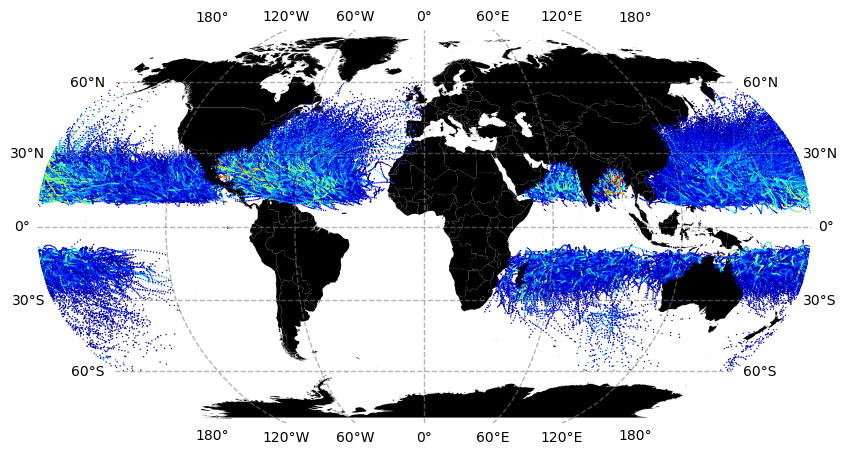

In [23]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()})
fig.set_size_inches(10,10)
ax.axis('off')

countries.plot(ax=ax, color = 'black', transform=ccrs.PlateCarree())
gdf.plot(ax=ax, markersize=1, alpha=1, edgecolors='none', column="Maximum Wind Speed",
        cmap='jet', transform=ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray',
            alpha=0.6, linestyle='--')

plt.show()

## Planar Projections
Commonly used for the poles. distortion increases rapidly from reference plane or point. The code below is identical to the previous Robinson projection example, except for the cartopy transformation in the first line of code. Here, I used Azimuthal Equidistant.

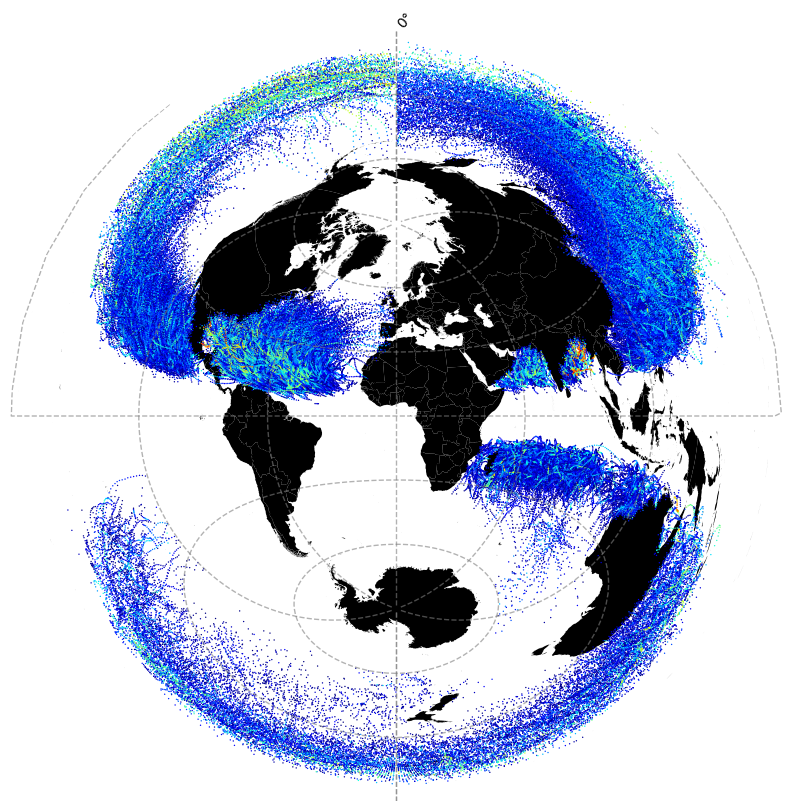

In [24]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.AzimuthalEquidistant()})
fig.set_size_inches(10,10)
ax.axis('off')

countries.plot(ax=ax, color = 'black', transform=ccrs.PlateCarree())
gdf.plot(ax=ax, markersize=1, alpha=1, edgecolors='none', column="Maximum Wind Speed",
        cmap='jet', transform=ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray',
            alpha=0.6, linestyle='--')

plt.show()

## Conical Projections
Good for mapping mid latitude regions that are long in the east-west direction or small areas.

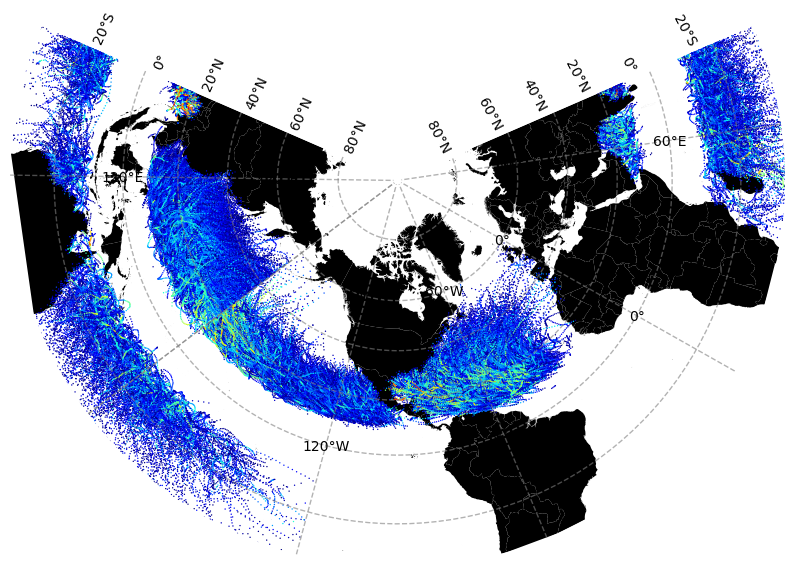

In [26]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.LambertConformal()})
fig.set_size_inches(10,10)
ax.axis('off')

countries.plot(ax=ax, color = 'black', transform=ccrs.PlateCarree())
gdf.plot(ax=ax, markersize=1, alpha=1, edgecolors='none', column="Maximum Wind Speed",
        cmap='jet', transform=ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray',
            alpha=0.6, linestyle='--')

plt.show()

## Cylindrical Projections
Some of the oldest projections. Preserve angles and shapes. Distort area and distance. 

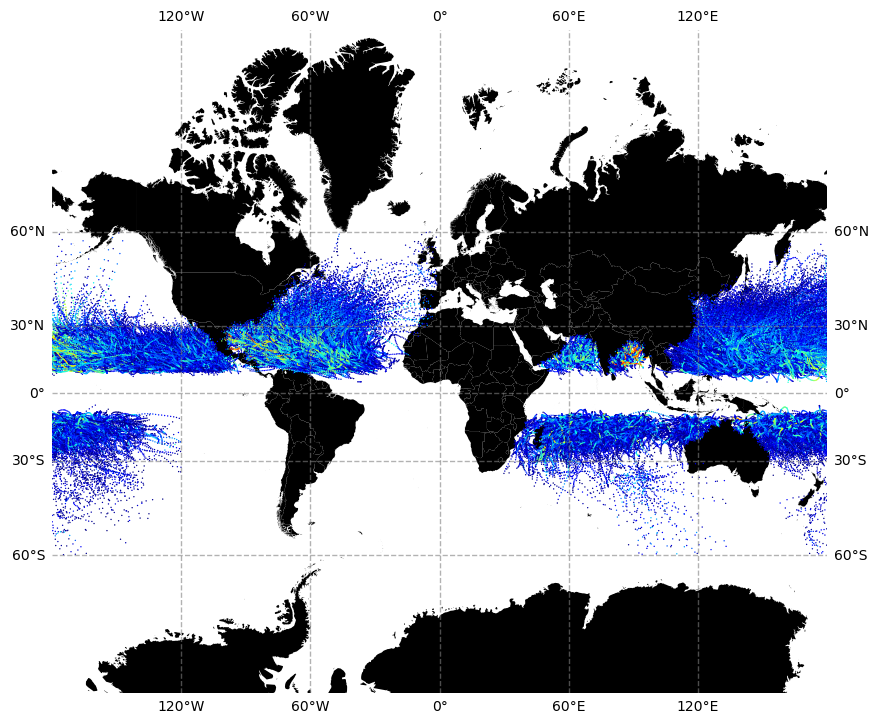

In [27]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Mercator()})
fig.set_size_inches(10,10)
ax.axis('off')

countries.plot(ax=ax, color = 'black', transform=ccrs.PlateCarree())
gdf.plot(ax=ax, markersize=1, alpha=1, edgecolors='none', column="Maximum Wind Speed",
        cmap='jet', transform=ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray',
            alpha=0.6, linestyle='--')

plt.show()

## The South Polar Stereographic Projection

Provides a great view of the southern hemisphere. Provides a different perspective of these tropical storms.

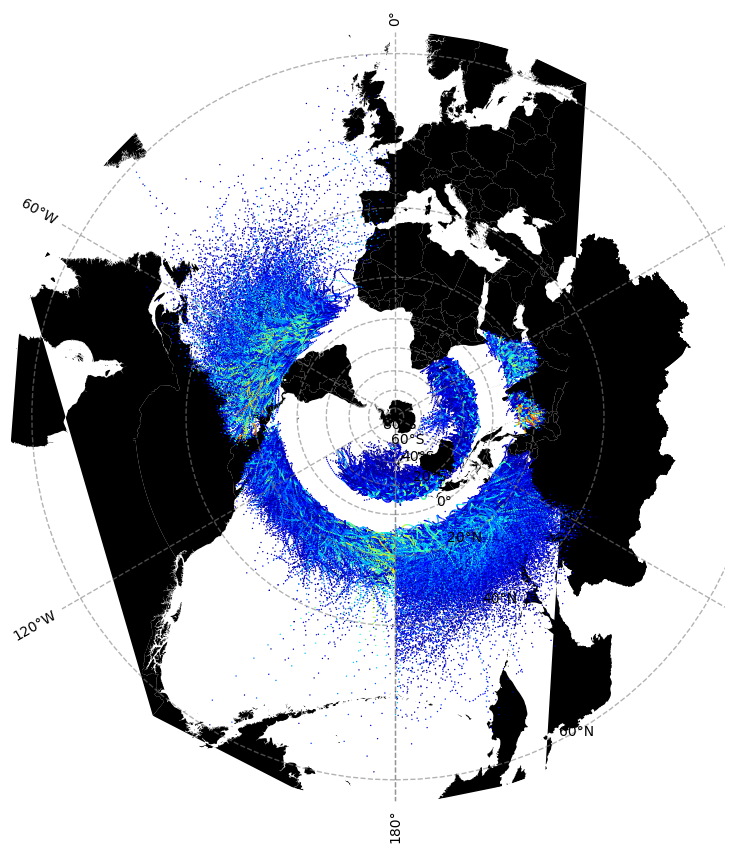

In [28]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.SouthPolarStereo()})
fig.set_size_inches(10,10)
ax.axis('off')

countries.plot(ax=ax, color = 'black', transform=ccrs.PlateCarree())
gdf.plot(ax=ax, markersize=1, alpha=1, edgecolors='none', column="Maximum Wind Speed",
        cmap='jet', transform=ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray',
            alpha=0.6, linestyle='--')

plt.show()